In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [16]:
def fetch_data(training_batch_size, testing_batch_size):
    mnist_train = datasets.MNIST('data_mnist', train=True, download=True,
                                 transform=transforms.Compose([transforms.ToTensor()]))
    train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=training_batch_size, shuffle=True)

    mnist_test = datasets.MNIST('data_mnist', train=False, download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))
    test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=testing_batch_size, shuffle=True)

    return train_data_loader, test_data_loader


In [17]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.dense1 = nn.Linear(784, 10)
        self.dense2 = nn.Linear(10, 20)
        self.dense3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x


In [18]:
def compute_metrics(mod, data_loader, criterion):
    mod.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 784)
            outputs = mod(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [19]:
def model_training_routine(model, epochs, train_dl, test_dl):
    optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    records = []

    for epoch in range(epochs):
        model.train()
        for images, labels in train_dl:
            optimizer.zero_grad()
            predictions = model(images.view(-1, 784))
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
        
        
        train_loss, train_acc = compute_metrics(model, train_dl, criterion)
        test_loss, test_acc = compute_metrics(model, test_dl, criterion)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        records.append((train_loss, train_acc, test_loss, test_acc))
    
    return pd.DataFrame(records, columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])


In [20]:
batch_train, batch_test = 1000, 1000
train_loader, test_loader = fetch_data(batch_train, batch_test)

model = BasicNN()
training_records = model_training_routine(model, 45, train_loader, test_loader)


Epoch 1/45, Train Loss: 2.0993, Train Acc: 0.3061, Test Loss: 2.0950, Test Acc: 0.3186
Epoch 2/45, Train Loss: 1.7218, Train Acc: 0.4682, Test Loss: 1.7096, Test Acc: 0.4799
Epoch 3/45, Train Loss: 1.2916, Train Acc: 0.6674, Test Loss: 1.2730, Test Acc: 0.6739
Epoch 4/45, Train Loss: 0.9557, Train Acc: 0.7630, Test Loss: 0.9351, Test Acc: 0.7715
Epoch 5/45, Train Loss: 0.7554, Train Acc: 0.8017, Test Loss: 0.7345, Test Acc: 0.8096
Epoch 6/45, Train Loss: 0.6382, Train Acc: 0.8256, Test Loss: 0.6188, Test Acc: 0.8363
Epoch 7/45, Train Loss: 0.5618, Train Acc: 0.8442, Test Loss: 0.5459, Test Acc: 0.8523
Epoch 8/45, Train Loss: 0.5077, Train Acc: 0.8562, Test Loss: 0.4938, Test Acc: 0.8645
Epoch 9/45, Train Loss: 0.4667, Train Acc: 0.8688, Test Loss: 0.4548, Test Acc: 0.8724
Epoch 10/45, Train Loss: 0.4352, Train Acc: 0.8763, Test Loss: 0.4254, Test Acc: 0.8782
Epoch 11/45, Train Loss: 0.4105, Train Acc: 0.8829, Test Loss: 0.4024, Test Acc: 0.8847
Epoch 12/45, Train Loss: 0.3903, Train Ac

/var/folders/5b/cl1s68wj1xb3_s270s4z7z3r0000gp/T/ipykernel_55160/1862861276.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(components[:, 0], components[:, 1], alpha=0.7, cmap='viridis')


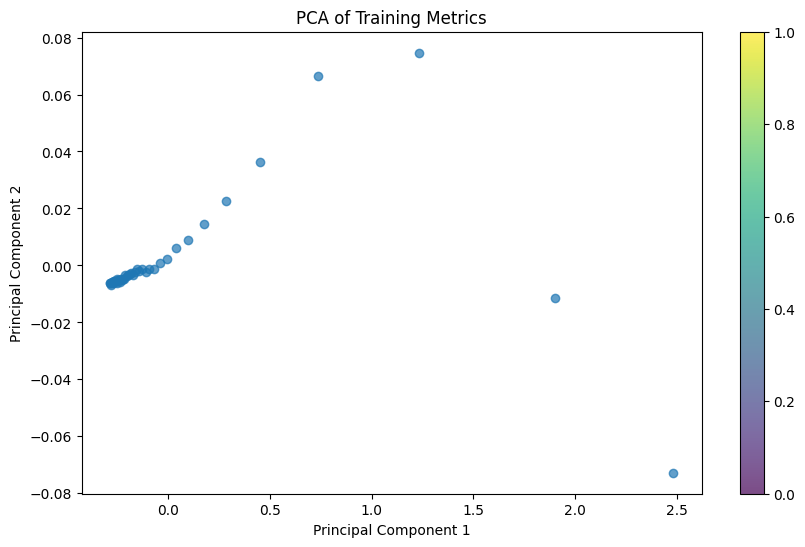

In [21]:

def visualize_pca(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df[['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc']])
    plt.figure(figsize=(10, 6))
    plt.scatter(components[:, 0], components[:, 1], alpha=0.7, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Training Metrics')
    plt.colorbar()
    plt.show()

visualize_pca(training_records)
